In [1]:
#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

# Sentinel 2 data

In [3]:
with rasterio.open(r'C:\Users\BSibiya\Desktop\PROSAIL-MODEL\sentinel-Image\sentinel_prosail.tif') as src:
    blue = src.read(1, masked=True) #B2
    green = src.read(2, masked=True) #B3
    red = src.read(3, masked=True) #B4
    Red_Edge_1 = src.read(4, masked=True) #B5
    Red_Edge_2 = src.read(5, masked=True) #B6
    Red_Edge_3 = src.read(6, masked=True) #B7
    nir = src.read(7, masked=True) #B8
    Red_Edge4 = src.read(8, masked=True) #B8A
    swir_1 = src.read(9, masked=True) #B11
    swir_2 = src.read(10, masked=True) #B12
    
np.seterr(divide='ignore', invalid='ignore')
VI_output = '/Users/BSibiya/Desktop/PROSAIL-MODEL/VI-output/'


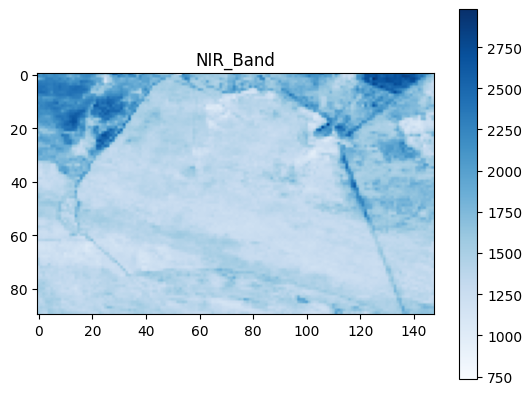

In [4]:
plt.imshow(nir, cmap='Blues')
plt.colorbar()
plt.title('NIR_Band')
plt.show()

# Function to calculate vegetation indices

In [13]:
#Function to calculate vegetation indices from band combinations
#Raster_output_name - name of the vegetation index which will be saved 
#VI_name - name of the vegetation index
#cmap_output_name - name of the png file where the file will be stored with colormap applied
#plot_title - title of the image produced 

def create_vegetation_indices(raster_output_name, VI_name, cmap_output_name, plot_title):
    np.seterr(divide='ignore', invalid='ignore')
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)
    
    with rasterio.open(VI_output + raster_output_name, 'w', **kwargs) as dst:
        dst.write_band(1, VI_name.astype(rasterio.float32))
    
    plt.imsave(VI_output + cmap_output_name, VI_name, cmap=plt.cm.RdYlGn)
    plt.imshow(VI_name, cmap=cm.RdYlGn)
    plt.colorbar()
    plt.title(plot_title)
    plt.show()
    
#Normalizes numpy arrays into scale -1.0 - 1.0
#array - indicates in this case the array of the image to normalize
def normalize(array):
    array_min, array_max = array.min(-1), array.max(1)
    return ((array - array_min)/(array_max - array_min))

#### Normalized Difference vegetation Index - NDVI

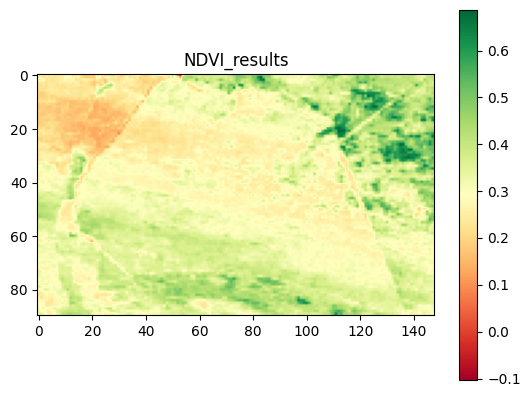

In [7]:
#Equation to calculate NDVI
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
#create NDVI bands with the use of create_vegetation_indices function from section 3 - user defined functions 
#The result will be written into tiff and png file with the colormap applied
#ndvi_results = create_vegetation_indices('1_NDVI.tif', ndvi, '1_NDVI_cmap.png', 'NDVI_results')

#### Soil Adjusted Vegetation Index - SAVI

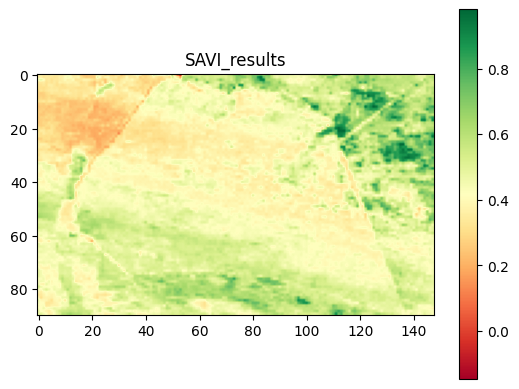

In [15]:
#Calculate SAVI 
l = 0.428 #L parameter assigned
savi = (nir.astype(float) - red.astype(float)) / (nir + red + l) * (1 + l)
#normalize raster results to scale: -1 tp 1:
#savi_n = normalize(savi)
#create SAVI band with the use of create_vegetation_indices function from section 3 - user-defined function
#savi_results = create_vegetation_indices('3_SAVI.tif', savi, '3_SAVI_cmap.png', 'SAVI_results')

# Create PROSAIL datasets of 1000 simulations

In [5]:
np.random.seed(0)
krange=1000
n=1.28
chloro= 18+rand(krange)*50
caroten=rand(krange)*20
brown=rand(krange)*1
EWT=rand(krange)*0.009
LMA=rand(krange)*0.009
LAI=1+rand(krange)*6
hot_spot=0.1
tts = 25.6800490939937 # solar zenith angle (in degrees)
tto = 0 # sensor/observer zenith angle (in degrees)
psi = 66.2901524550189 # Azimuth angle - difference between sun and sensor (in degrees)
typelidf=1 # Leaf angle distribution type
lidfa = -1 # leaf angle distribution parameter a and b (Spherical)
lidfb=0 # Leaf angle distribution
rsoil = 0,39  # Soil brigthness factor 
psoil = -0,12 # Dry/Wet soil factor

#soilType=pyPro4SAIL.DEFAULT_SOIL
#sal=len(solar_zenith)
#rho=np.zeros((sal,krange,2101))
rho_out = np.zeros((krange,2101))
for i in range(krange):
    rho_out[i,:] = prosail.run_prosail(n,chloro[i],caroten[i],brown[i], EWT[i], LMA[i], LAI[i], lidfa,hot_spot,tts,tto,psi, typelidf=1, lidfb=0,
                                 factor='DHR', rsoil=0.39, psoil=-0.12)


#### Print simulated spectra

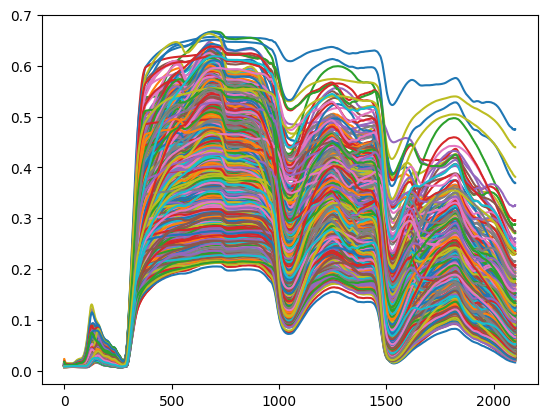

In [6]:
plt.plot(rho_out.T);

### Then a function to convert the input hyperspectral data to Sentinel 2A data using a weighted mean approach

In [18]:
#this function also transforms the hyperspectral data to sentinel data
def Prosail2S2(path2csv, spectra_input):
    #importing pandas
    import pandas as pd
    import numpy
    import numpy as np
    
    s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
    s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
    spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
    rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
    w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

    output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

    return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"

#### Now we combine hyperspectral data to suited Sentinel 2A data

In [20]:
tr_rho_s = np.zeros((10000, 10))
for i in range(1000):
    tr_rho_s[i, :] = Prosail2S2(filepath,  rho_out[i,0:2101].T)[np.array((1,2,3,4,5,6,7,8,11,12))]
print(tr_rho_s.shape)

S2_sim = pd.DataFrame(tr_rho_s, columns = ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'))


(10000, 10)


In [9]:
S2_sim

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12
0,0.010451,0.025372,0.009345,0.057126,0.210779,0.290234,0.341258,0.371394,0.329480,0.200151
1,0.016699,0.025741,0.008502,0.052577,0.228749,0.305640,0.336262,0.353456,0.261875,0.136754
2,0.010245,0.024415,0.008329,0.050686,0.180401,0.227304,0.246976,0.257922,0.215065,0.136578
3,0.010803,0.033472,0.009690,0.067055,0.286173,0.371418,0.394717,0.407348,0.264271,0.138749
4,0.019038,0.032845,0.010492,0.067167,0.227744,0.297067,0.334165,0.355326,0.273026,0.167300
...,...,...,...,...,...,...,...,...,...,...
995,0.009706,0.035283,0.016222,0.077983,0.170377,0.212830,0.244576,0.262981,0.262050,0.183488
996,0.009781,0.027821,0.009334,0.058708,0.203774,0.259407,0.284947,0.299304,0.268156,0.178205
997,0.010866,0.022297,0.007940,0.047168,0.283914,0.428252,0.475030,0.501414,0.303742,0.161664
998,0.011234,0.036014,0.013729,0.079606,0.223637,0.297617,0.353188,0.386224,0.262164,0.129997


### Plot sentinel2 simulated


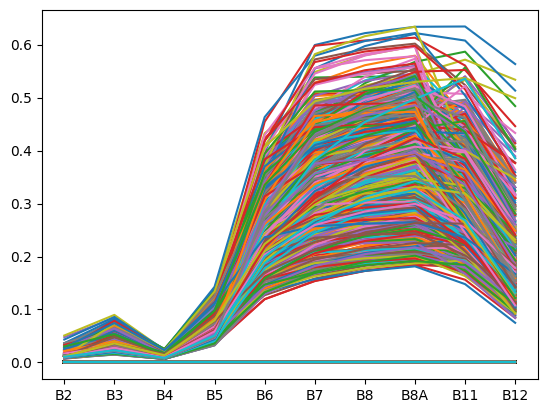

In [21]:
plt.plot(S2_sim.T);

# Upload Measured dataset

In [83]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [13]:
dataframe = r'C:\Users\BSibiya\Desktop\PROSAIL-MODEL\excel-bands\dataset.xlsx'
df = pd.read_excel(dataframe)

### Plot sentinel2 measured 

In [14]:
S2_meas = df[['B2', 'B3', 'B4', 'B5','B6', 'B7', 'B8','B8A', 'B11','B12']]
df_chloro = df[['CAB']]

In [15]:
S2_meas.head()

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12
0,819,679,559,766,1114,1302,1302,1511,1843,995
1,850,727,625,811,1138,1302,1368,1533,2044,1170
2,854,751,653,872,1266,1455,1525,1711,1970,1113
3,904,769,766,905,1263,1484,1454,1718,2135,1306
4,915,834,718,992,1343,1514,1735,1780,2255,1399


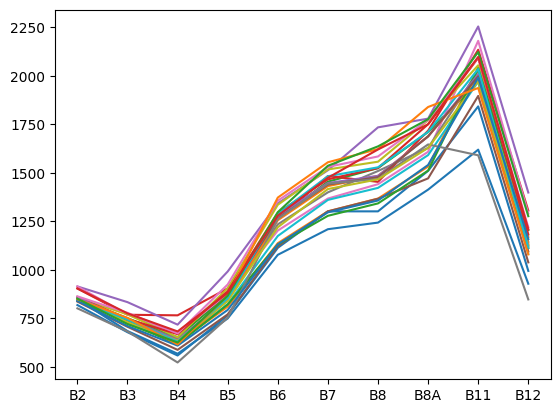

In [16]:
plt.plot(S2_meas.T);

# Calculate RMSE between simuulated and measured 

In [17]:
meas=np.array(S2_meas)/np.mean(np.array(S2_meas))*np.mean(np.array(S2_sim))
#cab = []
#rmse = []
for i in np.arange(40):
#     print(np.sum((np.array(simulated)-np.array(measured)[i,:])**2,axis=1))
    mses=np.sum((np.array(S2_meas)-meas[i,:])**2,axis=1)
    ind=np.argmin(mses)
    #cab.append(chloro[i])
    #print(chloro[i])
    print(ind, mses[ind])
    #rmse.append(mses[ind])
    
#chlorophyll = pd.DataFrame(cab, columns = ['chlor'])


691 0.027506092007671817
691 0.035670657904509004
990 0.0299138731751894
990 0.042544181178702616
43 0.04523181862199429
691 0.029937452951035535
43 0.04233427041518441
990 0.032115445146601515
990 0.03212192742793711
990 0.031236937009880957
691 0.0264376696513188
990 0.029917100098966247
691 0.03502877087109631
990 0.03436565835857904
990 0.03059408451701544
990 0.029469489260499675
990 0.034892762888889275
990 0.018900650026789596
990 0.030095163286554625
990 0.03008751537613714
691 0.03295703956127784
990 0.027067175031806445
931 0.03291922582775449
990 0.03689373726201753


IndexError: index 24 is out of bounds for axis 0 with size 24

In [92]:
#chlorophyll.head()

In [93]:
new_data_simulated = S2_sim.T
new_data_measured = S2_meas.T

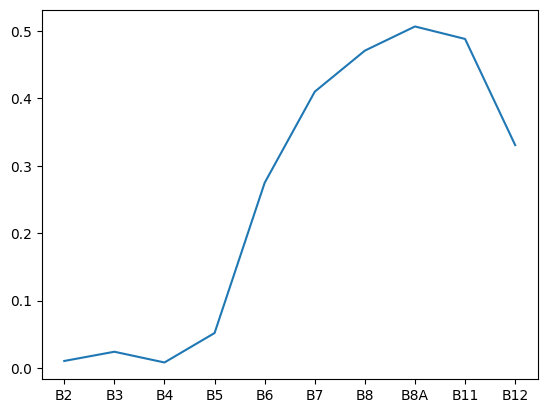

In [94]:
best_simulated = new_data_simulated[[10]]
plt.plot(best_simulated);

In [95]:
inner = pd.concat([new_data_measured, best_simulated], axis = 1)
inner

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,10
B2,819,850,854,904,915,837,915,860,855,848,...,840,864,802,850,844,841,849,852,905,0.010568
B3,679,727,751,769,834,707,770,744,771,732,...,735,779,683,731,744,711,753,721,776,0.024242
B4,559,625,653,766,718,588,671,645,653,623,...,622,673,523,635,630,610,616,626,683,0.008330
B5,766,811,872,905,992,771,878,844,906,824,...,870,925,754,840,854,794,868,867,882,0.051969
B6,1114,1138,1266,1263,1343,1122,1203,1235,1336,1175,...,1266,1357,1263,1220,1289,1132,1373,1298,1280,0.274635
B7,1302,1302,1455,1484,1514,1302,1368,1400,1518,1361,...,1440,1531,1445,1417,1483,1297,1555,1537,1475,0.409674
B8,1302,1368,1525,1454,1735,1367,1442,1510,1558,1423,...,1478,1585,1469,1467,1529,1358,1623,1637,1621,0.470520
B8A,1511,1533,1711,1718,1780,1472,1609,1629,1772,1592,...,1689,1774,1647,1629,1712,1541,1840,1777,1751,0.506308
B11,1843,2044,1970,2135,2255,1897,2181,2026,2055,1971,...,1998,2095,1591,1973,2036,1991,1938,2123,2098,0.487838
B12,995,1170,1113,1306,1399,1039,1291,1145,1129,1083,...,1095,1220,848,1121,1114,1159,1080,1277,1210,0.330509


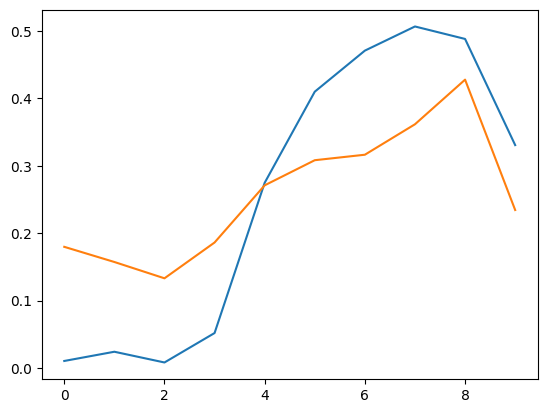

In [99]:
plt.plot(np.array(inner)[:,-1]);
plt.plot(np.array(inner)[:,15]/np.mean(np.array(inner)[:,15])*np.mean(np.array(inner)[:,-1]));